# Randomized benchmarking

# main code



## clliford gate selection
random gates selection from the Peter Karalekas senior thesis "Designing quantum algorithms for qubit control calibration"
https://github.com/pkaralekas/senior-thesis/blob/master/docs/thesis-writeup.pdf. 
since the compiler only support $RZ(\theta)$ and $RX(k\pi/2)$ the group is even smaller than the paper suggested.

## for loop
* m: the list of gate lengths for each program 
* trials: for each  program we should run it many times to get statistical results of error
* sequency_trials: for each same randomly generated program's statistical error, we should repeat to have a standard deviation

In [19]:
import numpy as np
from numpy.random import random_integers as rand
from mock import MagicMock
#import json

import pyquil
from pyquil.quil import Program
from pyquil.api import QVMConnection, QPUConnection, get_devices, Job,CompilerConnection
from pyquil.gates import *

import math
from random import randint
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import linalg
#matplotlib inline

# Set this flag if you want to send programs to Forest.
SEND_PROGRAMS = True

pi = math.pi
m = [1,2,4,8,16,36,60,80,100,128]  # sequence length list
bad_qubits = [2,3,15,18]  
full_list = range(20)   # 20 qubits chip

qubits_list = [i for i in full_list if i not in bad_qubits] # good qubits list

classical_regs_list = [[i] for i in range(20)]
classical_regs = [0]


sequence_trials = 5
fidelity = np.zeros(len(m))
fidelity_noisy = np.zeros((len(full_list),len(m)))
error_bar = np.zeros((len(full_list),len(m)))

trials = 1000


acorn = get_devices(as_dict=True)['19Q-Acorn']
qvm_noisy = QVMConnection(acorn)  # classical acorn model noisy simulation
qvm = QVMConnection()      #classical simulation
qpu = QPUConnection(acorn)

#if SEND_PROGRAMS:
#    qvm = QVMConnection()
    # QPU
#    online_devices = [d for d in get_devices() if d.is_online()]
#    if online_devices:
#        d = online_devices[0]
#        qpu = QPUConnection(d.name)
#        print("Found online device {}, making QPUConnection".format(d.name))
#    else:
#        qpu = QVMConnection()
#        print("Could not find online device, defaulting to QVM")
#else:
#    qpu = MagicMock(QPUConnection)
#    qpu_job = MagicMock(Job)
#    qpu.wait_for_job.return_value = qpu_job
#    qpu_job.result.side_effect = json.load(open("qpu.json", 'r'))

In [21]:
# the function use the random choice of n (1-4) to return/select random RX,RZ gate
def random_compiler_clifford(n,qubit): 
    list = {
        0:
            RX(pi/2)(qubit),
        1:
            RX(-pi/2)(qubit),
        2:
            RZ(pi/2)(qubit),   
        3:
            RZ(-pi/2)(qubit)
    }
    
    return list[n]

def random_compiler_clifford_inverse(n,qubit): 
    list = {
        0:
            RX(-pi/2)(qubit),
        1:
            RX(pi/2)(qubit),
        2:
            RZ(-pi/2)(qubit),   
        3:
            RZ(pi/2)(qubit)
    }
    
    return list[n]


for qubit in qubits_list:
    for index,j in enumerate(m):
        error = np.zeros(sequence_trials)
        for k in range(0,sequence_trials): # no of random sequence of same length

            #program, x series  initialization
            program = Program()
            x_series = np.zeros(j)
            
            program.inst("PRAGMA PRESERVE_BLOCK")
            #inside the preserve region, the complier will not touch it
            for i in range(0,j):
                x = randint(0, 3)
                x_series[i] = x
                program.inst(random_compiler_clifford(x,qubit))
            
            # apply m operations and then apply m inverse operations
            for i in range(0,j):
                x = x_series[j-1-i]
                program.inst(random_compiler_clifford_inverse(x,qubit))
            program.measure(qubit,classical_regs)
            #inside the preserve region, the complier will not touch it
            program.inst("PRAGMA END_PRESERVE_BLOCK")        

            error[k] = np.sum(qpu.run(program,classical_regs,trials,needs_compilation=False))/trials

        fidelity_noisy[qubit,index] = 1- sum(error) / float(len(error))
        error_bar[qubit,index] = np.std(error) 

    
    print ("fidelity data", qubit)
    print(fidelity_noisy[qubit])
    print ("error bar data", qubit)
    print (error_bar[qubit])
    print ("----------------------------")


job HLDTOXxYmBpGahEE is currently running
job HLJxsRQjknlonAbE is currently running
job PknuhbobRjntEkMd is currently running
job DixyFlQpOukHSDdt is currently running
job jHAICcYNvxydBRtr is currently running
job vXuAMsrluEuVGlHa is currently running
job UsFQZusoYlsmBxaE is currently running
job yfMtGwmuQvdUluuR is currently running
job NeFVdKrxqUbxsdaD is currently running
job TvoEpvUvqcMayYBG is currently running
job thzwKUxOuJobxbSU is currently running
job VWyYpZRzXKzYMDvC is currently running
job lLZPWxXIMgSQaElq is currently running
job sbiSlAkFgTxUBOkZ is currently running
job JjIknPtplAfHchdO is currently running
job gzToQyXJrRUCtjeW is currently running
job wSPzturQyUbrmXyq is currently running
job zwXgfbPKhVrFhDyt is currently running
job naUInMVlHDULiqey is currently running
job UcwZsTGZxxhVeDTD is currently running
job vOsffaVPlQttLptJ is currently running
job wrbJDFZdMuZnWmPe is currently running
job vKrYPJTxKEkhLQMh is currently running
job sJUYzuxALHRCvIGI is currently 

job xXcQAAYgyIyHJXXE is currently running
job gQNnfuScvNTrYUHR is currently running
job XdmNhrGtkeBWbXDx is currently running
job ypEJXOTWFplTmFdf is currently running
job JyWLKADnTqrmrmcZ is currently running
job scUwyXdcmRJjUkBk is currently running
job AvdwUsKttXSJMwFl is currently running
job IygnAJYoEUAlVCbt is currently running
job BunLFmfwWTqKknjo is currently running
job kdRaEukWpXEsoOYO is currently running
job UWsirjFMCSDStUov is currently running
job CGjDBaIuZuCaIwKG is currently running
job qNzivngoUtaftMFx is currently running
job HMMhZfMVkBMdZWSh is currently running
job EqSTJqtOivCLtdsC is currently running
job rhoGZNgqmkVYlzzJ is currently running
job fMxOAcCWfOhFYnKP is currently running
job ENtJrzmVQeyopyDi is currently running
job UTgJmsTaounoCwkC is currently running
job RWxJcrVfWgawpXiW is currently running
job ZWxXnEsJDQqPQKaH is currently running
job HsKQvljlOPnAMDhO is currently running
fidelity data 5
[0.9022 0.8876 0.8864 0.8552 0.82   0.7516 0.6178 0.6504 0.6

job GzpiQkRnsXiZaFQd is currently running
job dhsUxuAQbaVufIaW is currently running
job zNLVnqnfXHMUlihb is currently running
job NZILCnCtaoAKUQIn is currently running
job plMyvrfGoaoirIph is currently running
job epFtlDGsVSohfakC is currently running
job QHfyawlBqVBqjywz is currently running
job dtoJAhaJMIfAEjrw is currently running
job BPLyHNlNPKdmcqUC is currently running
job lsRCqOrvhjglLqKt is currently running
job gKSHCHnoRPvBvzGl is currently running
job OvXmUYsdLItIizgm is currently running
job uzEgREAJdFIqCAEE is currently running
job qUNWIylUQLaLazkW is currently running
job KderbTlEByEvUYtj is currently running
job oXBueieGJTJTUMdS is currently running
job TLwPFOxTZJSlJKas is currently running
job wlOirpvGgcMxkSuH is currently running
job JxGpYifIMdEnYOxL is currently running
job RDkoTXLZXIohhBuP is currently running
job XdHgLvqiKraqhZLG is currently running
job HigncZtEhqtpQjBV is currently running
job tRdoZcTRfDKixcdC is currently running
job VCoTIaLsqFkFUhKi is currently 

job GdGsDvtTqHpgdFYU is currently running
job VTwAkDitHiRjCXOC is currently running
job YliuWTlLVNBatsTe is currently running
job oWwYElpaCNVDWpod is currently running
job QCboKrWQirzchDuf is currently running
job uVthpAAMJOIGoEee is currently running
job jhHYptGQakqXHmLW is currently running
job goKgAZRgKajppeJE is currently running
job rEYMFMzuZcWkZdPt is currently running
job CwSdFSligCyczPkG is currently running
job WuznyTHHEvdBKcJc is currently running
job lysSIFdJGsbUpjCP is currently running
job smtjHfgavprUOQXz is currently running
job IRkqezWzWDgyXNbr is currently running
job PrZciPudckREErSE is currently running
job BJshVgegkjOERMfy is currently running
job FIzXsdPROvjYhfEu is currently running
job RQIHmpOqtUIItDFp is currently running
job CvcUWVobKWhWugoM is currently running
job jcBusmzFRYLiBJNW is currently running
job bxghAuoNuoDypSsW is currently running
fidelity data 12
[0.983  0.9888 0.9662 0.9498 0.9278 0.8824 0.737  0.7444 0.671  0.656 ]
error bar data 12
[0.00898888

job odDTAYFZxKgVOyZA is currently running
job RCygEtWCCOHHvGHe is currently running
job BNmwQjqvZyioBPiY is currently running
job RZuEQnYYuabfcnCx is currently running
job PYPgNlqJdoNBXWGM is currently running
job wybUTkVTjhHRpHXc is currently running
job fWlohqjSWFOHWnNc is currently running
job skkfrsEsExAxmGDZ is currently running
job cwSbhQokPfUbDbBF is currently running
job LutSSNxDmWgqvcFV is currently running
job zINcKRkxSgduQmAy is currently running
job aNEWCYQMeADDSRjK is currently running
job TmHFaApQaJeGvVoa is currently running
job ZtojpFudCXlfGZWo is currently running
job ohTKSZRXnNRXDVMC is currently running
job nAGrYOXASpKtMwka is currently running
job eiPaAYJaRhiycJyb is currently running
job VHXWwekGQwmsFHAN is currently running
job DXFGcOWDyukqyJba is currently running
job JezEUbOgAaFTtGXN is currently running
job OhgSFqnXajVNAwmo is currently running
job cppXIuzFWdoxpClg is currently running
job sYijwWjMtJbWWrhy is currently running
job nqfziPKSkzkJIhIl is currently 

In [22]:
print(fidelity_noisy)

[[0.953  0.9478 0.948  0.9074 0.929  0.88   0.8522 0.8098 0.825  0.7906]
 [0.8588 0.85   0.8474 0.8376 0.8008 0.7778 0.7536 0.6624 0.6784 0.66  ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.9868 0.9826 0.9762 0.9638 0.9314 0.9032 0.8632 0.7716 0.731  0.7014]
 [0.9022 0.8876 0.8864 0.8552 0.82   0.7516 0.6178 0.6504 0.6328 0.6556]
 [0.9192 0.9124 0.9072 0.8834 0.8418 0.8356 0.8192 0.7912 0.7748 0.7032]
 [0.8556 0.8456 0.8496 0.8478 0.8428 0.8224 0.7768 0.7822 0.7672 0.7268]
 [0.9848 0.981  0.9774 0.971  0.9618 0.9182 0.8956 0.8602 0.8372 0.799 ]
 [0.9606 0.9394 0.9388 0.9278 0.8934 0.776  0.6832 0.613  0.583  0.5446]
 [0.8732 0.8746 0.8614 0.8462 0.8304 0.7902 0.7154 0.7124 0.6428 0.6314]
 [0.9568 0.954  0.9424 0.9316 0.9214 0.8634 0.8334 0.8004 0.8272 0.7282]
 [0.983  0.9888 0.9662 0.9498 0.9278 0.8824 0.737  0.7444 0.671  0.656 ]
 [0.983  0.9852 0.9832 0.9456 0.9328 0.9014 0.7928 

# fitting model 
from paper "Scalable and Robust Randomized Benchmarking of Quantum Processes" (E Magesan,et al 2011)
https://arxiv.org/pdf/1009.3639.pdf

\begin{equation*}
F_{seq} = Ap^m+B
\end{equation*}

where A,B,p are fitting parameters and p is the decay rate and A.B absorbs state preparation and measurement errors as well as the error on the final gate. the total gate operation is 2m in each program but the computational basis operation is still m.

the single qubit gate fidelity d = 2.

\begin{equation*}
 r = 1 - p - (1-p)/ d.    
\end{equation*}

\begin{equation*}
 F = p +(1−p)/ 2  
\end{equation*}



[0.19657435 0.98753417 0.75460382]
average decay rate p =  0.9875341657068607


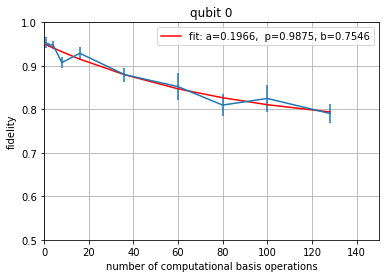

[0.27202042 0.98899541 0.58637421]
average decay rate p =  0.9889954058447323


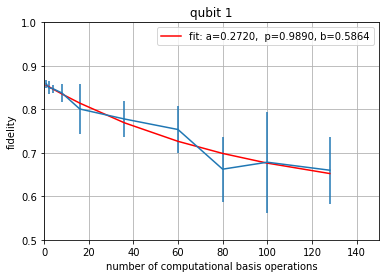

[0.68953629 0.99568675 0.3       ]
average decay rate p =  0.9956867481569218


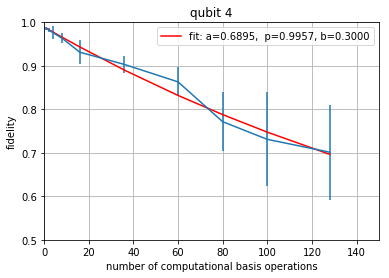

[0.29251465 0.9707324  0.62294356]
average decay rate p =  0.9707324034070939


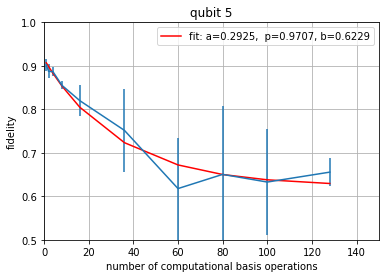

[0.60501807 0.99716811 0.3       ]
average decay rate p =  0.9971681059935965


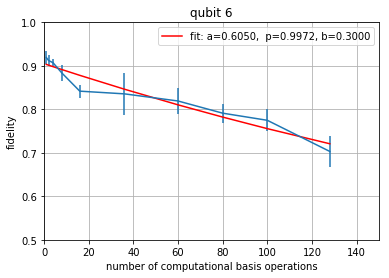

[0.55456176 0.99807166 0.3       ]
average decay rate p =  0.9980716596701116


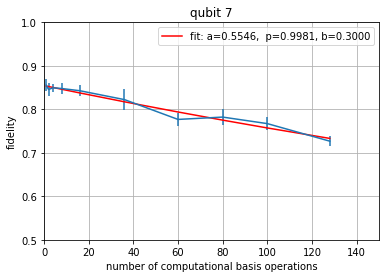

[0.61241771 0.99719865 0.37258385]
average decay rate p =  0.9971986537490107


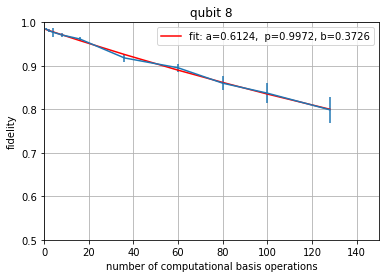

[0.55153696 0.9880758  0.41715368]
average decay rate p =  0.9880757950774739


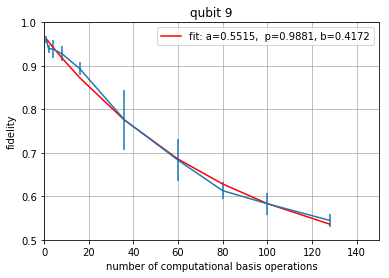

[0.40968075 0.99261884 0.4663046 ]
average decay rate p =  0.9926188362474708


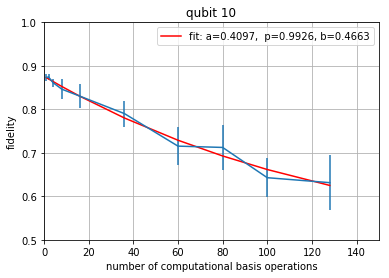

[0.36431263 0.99369759 0.58912949]
average decay rate p =  0.9936975935381288


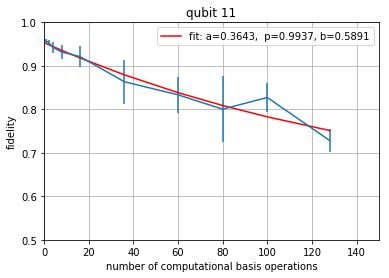

[0.48434272 0.99013093 0.508501  ]
average decay rate p =  0.9901309342036086


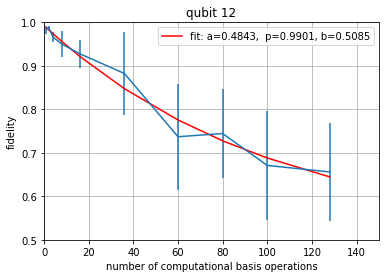

[0.69347363 0.99436478 0.3       ]
average decay rate p =  0.9943647827676083


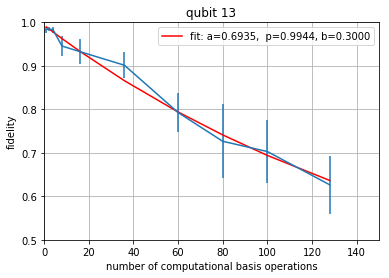

[0.44059833 0.98819032 0.55043889]
average decay rate p =  0.988190315404468


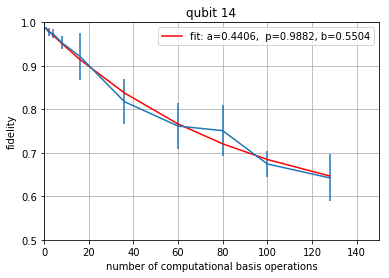

[0.17266932 0.98581273 0.76902603]
average decay rate p =  0.9858127258854835


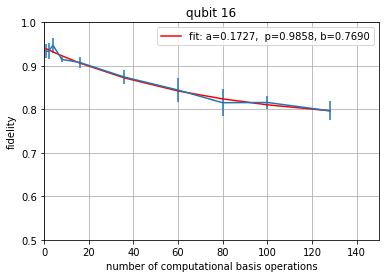

[0.41343431 0.996132   0.47898307]
average decay rate p =  0.9961319986188748


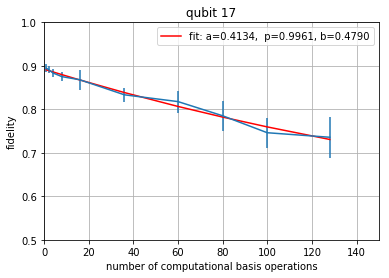

[0.68460014 0.99784705 0.3       ]
average decay rate p =  0.9978470525904013


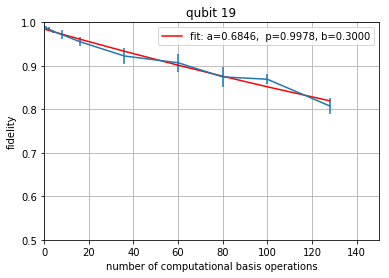

In [27]:
def gate_independence_fit(x,a,p,b):
    return a*p**x+b
    # a,b,p fitting parameters, p is the decay rate and a,b will absorbs initialization / measurement errors

decay_rate = np.zeros(len(full_list))

xdata = m
for i in qubits_list:

    ydata = fidelity_noisy[i]
    error = error_bar[i]
    popt,pcov = curve_fit(gate_independence_fit,xdata,ydata,bounds = ([0,0.8,0.3],1))
    print(popt)
    decay_rate[i] = popt[1]
    print("average decay rate p = ",  decay_rate[i])

    
    plt.errorbar(xdata, ydata, yerr=error)
    plt.plot(xdata,gate_independence_fit(xdata,*popt),'r-',label = 'fit: a=%5.4f,  p=%5.4f, b=%5.4f' %tuple(popt))
    plt.grid()
    plt.yscale('linear')
    plt.axis([0, 150, 0.5, 1.0])
    plt.ylabel("fidelity")
    plt.xlabel("number of computational basis operations")
    plt.title("qubit " + str(i))
    plt.legend()
    plt.savefig("second fidelity_plot qubit" + str(i))
    plt.show()



In [24]:
print(decay_rate)

[0.98753414 0.98899543 0.         0.         0.99320248 0.97073263
 0.99537757 0.99677635 0.99629704 0.98374632 0.99159545 0.99369766
 0.99013083 0.99081636 0.98819031 0.         0.9858127  0.99587187
 0.         0.99678881]


In [25]:
fidelity = np.zeros(len(full_list))
fidelity = decay_rate+ (1-decay_rate)/2
print(fidelity)
# ignore bad qubits show 0.5 fidelity below

[0.99376707 0.99449772 0.5        0.5        0.99660124 0.98536632
 0.99768879 0.99838818 0.99814852 0.99187316 0.99579773 0.99684883
 0.99506542 0.99540818 0.99409515 0.5        0.99290635 0.99793594
 0.5        0.99839441]
